In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ts = joblib.load('../../bld/out/data_processed/BTC_POT.p.lzma')

In [22]:
ts

,BTC_POT_CLOSE,BTC_POT_HIGH_LAG_1,BTC_POT_LOW_LAG_1,BTC_POT_OPEN_LAG_1,BTC_POT_QUOTEVOLUME_LAG_1,BTC_POT_VOLUME_LAG_1,BTC_POT_WEIGHTEDAVERAGE_LAG_1,BTC_POT_HIGH_LAG_2,BTC_POT_LOW_LAG_2,BTC_POT_OPEN_LAG_2,...,BTC_POT_OPEN_LAG_5,BTC_POT_QUOTEVOLUME_LAG_5,BTC_POT_VOLUME_LAG_5,BTC_POT_WEIGHTEDAVERAGE_LAG_5,MA_20,MA_50,MA_200,DIFF_20_50,REGIME,SIGNAL
date,,,,,,,,,,,,,,,,,,,,,
2014-07-15 01:00:00,0.000017,0.000017,0.000017,0.000017,1000.000000,0.016880,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,NaN
2014-07-15 01:05:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:10:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:15:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:20:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:25:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:30:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:35:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0
2014-07-15 01:40:00,0.000017,0.000017,0.000017,0.000017,0.000000,0.000000,0.000017,0.000017,0.000017,0.000017,...,0.000017,0.000000,0.000000,0.000017,NaN,NaN,NaN,NaN,0,0.0


In [3]:
# Restriction to chart data only
ts = ts[ts.CHART == True].dropna(axis=1).drop(['CHART', 'TRADE'], axis=1)

# Moving averages

Here, I will be demonstrating a moving average crossover strategy. We will use two moving averages, one we consider “fast”, and the other “slow”. The strategy is:

Trade the asset when the fast moving average crosses over the slow moving average.
Exit the trade when the fast moving average crosses over the slow moving average again.

The fast version is a 20-day moving average and the slow one a 50-day moving average.

In [4]:
def moving_average(series, window):
    return series.rolling(window=window).mean()

In [5]:
ts['MA_20'] = moving_average(ts.BTC_POT_CLOSE, 12*24*20)
ts['MA_50'] = moving_average(ts.BTC_POT_CLOSE, 12*24*50)
ts['MA_200'] = moving_average(ts.BTC_POT_CLOSE, 12*24*200)

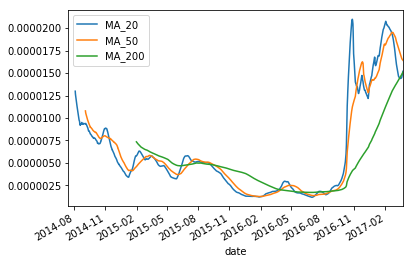

In [6]:
ts[['MA_20', 'MA_50', 'MA_200']].plot()

In [7]:
ts['DIFF_20_50'] = ts.MA_20 - ts.MA_50

In [8]:
ts['REGIME'] = np.where(ts.DIFF_20_50 > 0, 1, 0)

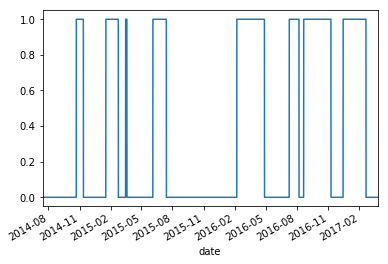

In [9]:
ts.REGIME.plot()

In [10]:
ts['SIGNAL'] = ts.REGIME - ts.REGIME.shift(1)

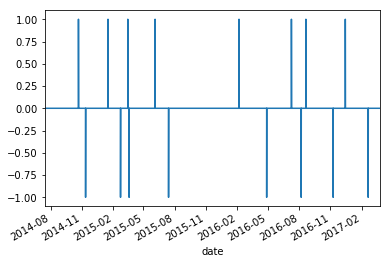

In [11]:
ts.SIGNAL.plot()

**Numpy**

In [23]:
signals = ts.SIGNAL.as_matrix()

In [33]:
np.in1d(signals, [-1, 1])

array([False, False, False, ..., False, False, False], dtype=bool)

In [61]:
trades = np.array([
    ts.BTC_POT_CLOSE[np.in1d(signals, [-1, 1])],
    signals[np.in1d(signals, [-1, 1])]
])

In [55]:
trades[0]

array([  8.50000000e-06,   6.06000000e-06,   3.77000000e-06,
         5.47000000e-06,   5.96000000e-06,   5.24000000e-06,
         5.15000000e-06,   5.01000000e-06,   1.62000000e-06,
         1.74000000e-06,   1.81000000e-06,   1.31000000e-06,
         2.46000000e-06,   1.55000000e-05,   2.72000000e-05,
         1.82000000e-05])

In [63]:
profits = (trades[0] - np.roll(trades[0], 1)) / trades[0]

In [65]:
a = np.array([1, 2])

In [66]:
a[2] = 3

IndexError: index 2 is out of bounds for axis 0 with size 2

In [64]:
sum(profits[trades[1] == -1])

-0.22313189391906196

**Continuation with Pandas**

In [12]:
profit = ts[(ts.SIGNAL != 0) & ts.SIGNAL.notnull()]

In [13]:
profit['RETURNS'] = (profit.BTC_POT_CLOSE - profit.BTC_POT_CLOSE.shift(1)) / profit.BTC_POT_CLOSE

C:\Users\tobia\AppData\Local\conda\conda\envs\crypto\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [15]:
profit.loc[profit.SIGNAL == 1, 'RETURNS'] = 0

C:\Users\tobia\AppData\Local\conda\conda\envs\crypto\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
profit[['BTC_POT_CLOSE', 'SIGNAL', 'RETURNS']]

,BTC_POT_CLOSE,SIGNAL,RETURNS
date,,,
2014-10-21 16:20:00,0.000008,1.0,0.000000
2014-11-11 14:50:00,0.000006,-1.0,-0.402640
2015-01-16 15:45:00,0.000004,1.0,0.000000
2015-02-22 11:25:00,0.000005,-1.0,0.310786
2015-03-15 20:45:00,0.000006,1.0,0.000000
2015-03-19 17:40:00,0.000005,-1.0,-0.137405
2015-06-04 02:50:00,0.000005,1.0,0.000000
2015-07-13 20:05:00,0.000005,-1.0,-0.027944
2016-02-06 04:15:00,0.000002,1.0,0.000000


In [18]:
profit.RETURNS.sum()

-0.22313189391906196

In [19]:
a = profit.RETURNS